In [11]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
import random

print("Using TensorFlow version:", tf.__version__)

# Pour reproduire un comportement stable (optionnel)
tf.random.set_seed(42)

Using TensorFlow version: 2.19.0


## 1. Chargement du dataset

In [ ]:


# Configuration
DATA_DIR = "screw_dataset"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

# Fonctions de transformation
def rotate_image(image, angle_degrees):
    return tf.image.rot90(
        image, 
        k=int(round(angle_degrees / 90)) % 4
    )

def specialized_augmentation(image):
    """
    Augmentations simulant des défauts réels
    """
    transforms = [
        # Simulation de rayures
        lambda img: tf.image.adjust_contrast(img, random.uniform(1.5, 2.5)),
        
        # Variations de géométrie du filetage
        lambda img: rotate_image(img, random.choice([-10, 10])),
        
        # Simulation d'imperfections de surface
        lambda img: tf.image.random_brightness(img, max_delta=0.2),
        
        # Variations de texture
        lambda img: tf.image.adjust_saturation(img, random.uniform(0.5, 2.0))
    ]
    
    # Combiner aléatoirement les transformations
    selected_transforms = random.sample(transforms, random.randint(1, 2))
    
    transformed = image
    for transform in selected_transforms:
        transformed = transform(transformed)
    
    return tf.clip_by_value(transformed, 0.0, 1.0)

# Focal Loss pour gérer le déséquilibre des classes
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_sum(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) \
               -tf.reduce_sum((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))
    return focal_loss_fixed

# Fonction de data augmentation
def data_augmentation(X_train, y_train, BATCH_SIZE=32):
    # Trouver les indices des images "bad" et "good"
    bad_indices = np.where(y_train[:, 0] == 0)[0]
    good_indices = np.where(y_train[:, 0] == 1)[0]
    
    X_bad = X_train[bad_indices]
    X_good = X_train[good_indices]

    print(f"Nombre d'images 'bad' avant augmentation: {len(X_bad)}")
    print(f"Nombre d'images 'good' avant augmentation: {len(X_good)}")

    # Générer des images augmentées
    X_bad_augmented = []
    y_bad_augmented = []

    # Générer des augmentations jusqu'à atteindre le nombre d'images 'good'
    np.random.seed(42)
    remaining_count = len(X_good)
    
    while len(X_bad_augmented) < remaining_count:
        # Choisir une image source
        img_source = X_bad[len(X_bad_augmented) % len(X_bad)]
        
        # Appliquer la transformation
        transformed_img = specialized_augmentation(img_source)
        
        # Ajouter l'image
        X_bad_augmented.append(transformed_img.numpy())
        y_bad_augmented.append(0)

    # Convertir en arrays numpy
    X_bad_augmented = np.array(X_bad_augmented)
    y_bad_augmented = np.array(y_bad_augmented).reshape(-1, 1)

    # Combiner avec les images "good"
    X_train_balanced = np.concatenate([X_good, X_bad_augmented])
    y_train_balanced = np.concatenate([
        y_train[good_indices], 
        y_bad_augmented
    ])

    # Mélanger le nouvel ensemble d'entraînement
    indices = np.arange(len(X_train_balanced))
    np.random.shuffle(indices)
    X_train_balanced = X_train_balanced[indices]
    y_train_balanced = y_train_balanced[indices]

    # Créer un nouveau dataset TensorFlow
    train_dataset_balanced = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))
    train_dataset_balanced = train_dataset_balanced.shuffle(buffer_size=len(X_train_balanced)).batch(BATCH_SIZE)

    return X_train_balanced, y_train_balanced, train_dataset_balanced

# Préparation des données
# Charger les images

print("Chargement des images...")
dataset = image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Extraction des images et labels
all_images = []
all_labels = []
for images, labels in dataset:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X = np.concatenate(all_images, axis=0)
y = np.concatenate(all_labels, axis=0)

# Mélange des données
indices = np.arange(X.shape[0])
np.random.seed(SEED)
np.random.shuffle(indices)
X_shuffled = X[indices]
y_shuffled = y[indices]

# Division train/validation/test
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_shuffled, y_shuffled, train_size=0.7, stratify=y_shuffled, random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=SEED
)

# Data augmentation
X_train_balanced, y_train_balanced, train_dataset = data_augmentation(X_train, y_train.reshape(-1, 1), BATCH_SIZE)

# Création des datasets de validation et test
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)


Chargement des images...
Found 1152 files belonging to 2 classes.
Nombre d'images 'bad' avant augmentation: 199
Nombre d'images 'good' avant augmentation: 607


## 2. Définition d'un modèle simple
On définit un modèle CNN

In [13]:
#encodeur

# Charger VGG16 pré-entraîné
base_model = models.Sequential([
    layers.Lambda(preprocess_input, input_shape=(224, 224, 3)),  # Pré-processing intégré
    VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
])
base_model.trainable = False  # On fige les poids du VGG16

model = models.Sequential([

    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Recall(name='recall')]
)

model.summary()

c:\Users\hlern\Desktop\Hetic_Screw_Project\Hl_Branch\venv\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 3. Entraînement du modèle

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # Réduction du LR par un facteur de 2
    patience=5,       # Attendre 3 époques sans amélioration avant de réduire
    min_delta=0.001,  # Seuil minimum de variation pour considérer une amélioration
    min_lr=1e-6       # LR minimum pour éviter d'aller trop bas
)

#class_weights = {0: 1., 1: 2.35}

# Entraînement
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset, 
    callbacks=[early_stopping, reduce_lr],
    #class_weight=class_weights, 
    verbose=1
)

# Fine Tuning

print("Activation du Fine-Tuning sur les 4 dernières couches")

for layer in base_model.layers[1].layers[-2:]:  
    layer.trainable = True 


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Réduction du LR pour ne pas casser les poids
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

# Fine-Tuning avec couches débloquées
history_finetune = model.fit(
    train_dataset, 
    epochs=10,  # On refait quelques epochs pour affiner l’apprentissage
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

print("Fine-Tuning terminé")

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 751ms/step - accuracy: 0.4935 - loss: 1.3011 - recall: 0.5166 - val_accuracy: 0.7514 - val_loss: 0.7586 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 770ms/step - accuracy: 0.5280 - loss: 0.8187 - recall: 0.5644 - val_accuracy: 0.2486 - val_loss: 0.7697 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 757ms/step - accuracy: 0.5333 - loss: 0.7410 - recall: 0.6410 - val_accuracy: 0.2486 - val_loss: 0.7576 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 743ms/step - accuracy: 0.4982 - loss: 0.7147 - recall: 0.4222 - val_accuracy: 0.7399 - val_loss: 0.6841 - val_recall: 0.9769 - learning_rate: 1.0000e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 746ms/step - accuracy: 0.4651 - loss: 0.7060 - recall: 0.6449 - val_accuracy: 0.3237 - val_loss: 0.7023 - val_recall: 0.1231 - learning_rate: 1.0000e-04
Epoch 6/50
38/38 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
✅ Seuil optimal pour Recall ≥ 99.0% : 0.6000


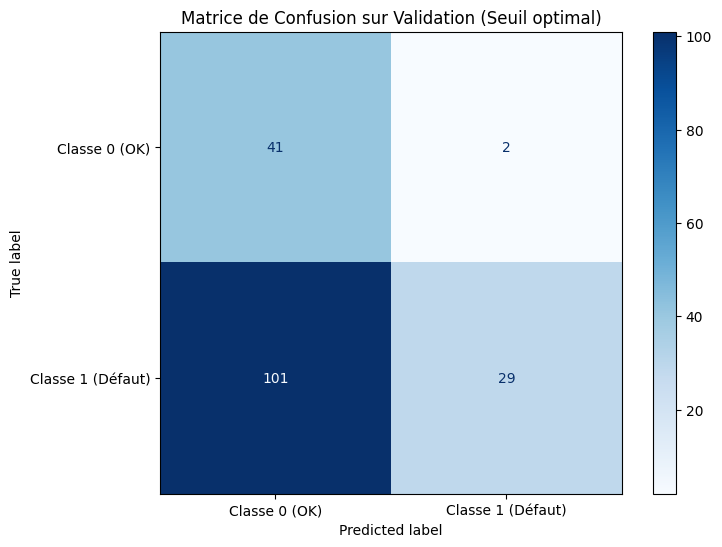

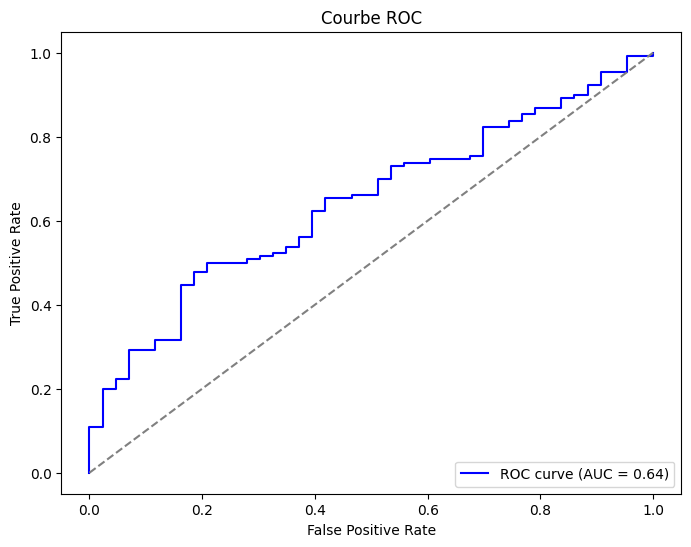

In [ ]:
# Ajout de la courbe ROC, AUC et Precision-Recall après l'entraînement

y_true = []
y_scores = []

# On extrait les prédictions et les vraies valeurs une seule fois clairement :
for x_batch, y_batch in val_dataset:
    y_true.extend(y_batch.numpy())  
    y_scores.extend(model.predict(x_batch).flatten())  

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calcul de la courbe ROC
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Calcul de la courbe Precision-Recall pour seuil optimal selon Recall minimal
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)

# On fixe un Recall minimum (99% pour protéger au maximum la réputation)
recall_min = 0.99

# Trouver le seuil optimal correspondant au Recall minimal requis
optimal_threshold = pr_thresholds[np.where(recall >= recall_min)[0][-1]]

optimal_threshold = 0.5

print(f"✅ Seuil optimal pour Recall ≥ {recall_min*100:.1f}% : {optimal_threshold:.4f}")

# Prédictions finales avec seuil optimal
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

# Calcul et affichage clair de la matrice de confusion
cm = confusion_matrix(y_true, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe 0 (OK)', 'Classe 1 (Défaut)'])

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Matrice de Confusion sur Validation (Seuil optimal)')
plt.show()

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()




## 4. Évaluation sur le même dataset

In [ ]:
# Obtenir les probabilités des prédictions sur le test set
y_scores_test = model.predict(X_test).flatten()  # Sorties sigmoïdes entre 0 et 1

# Appliquer le seuil optimal trouvé avec la courbe ROC  
y_pred_test = (y_scores_test >= optimal_threshold).astype(int)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)  # Ajout du F1-score

# Affichage des résultats
print(f"Accuracy avec seuil optimal ({optimal_threshold:.4f}) : {accuracy:.4f}")
print(f"Précision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 574ms/step
Accuracy avec seuil optimal (0.6000) : 0.3237
Précision : 0.7407
Recall : 0.1538
F1-score : 0.2548
